In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

C:\Users\nito8\AppData\Local\Temp\ipykernel_20128\1759108789.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max").ffill()
[*********************100%***********************]  1 of 1 completed


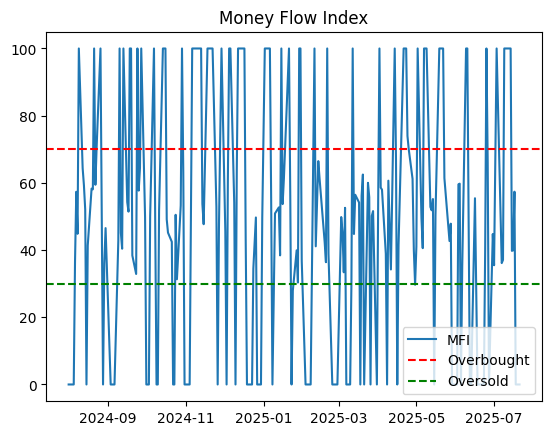

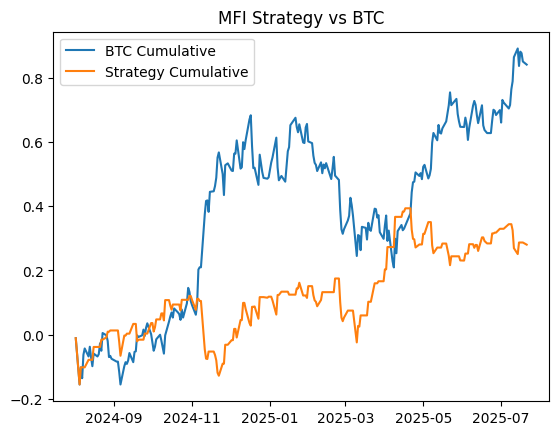

In [2]:
TICKER = 'BTC'
MFI_LENGTH = 2
OVERBOUGHT = 70
OVERSOLD = 30
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK):
    df = yf.download(ticker, period="max").ffill()
    df.columns = df.columns.get_level_values(0)
    return df.iloc[-lookback:, :]

def add_MFI(df, length=MFI_LENGTH, overbought=OVERBOUGHT, oversold=OVERSOLD):
    df = df.copy()

    # Calculate typical price
    df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Calculate raw money flow
    df['Raw_Money_Flow'] = df['Typical_Price'] * df['Volume']

    # Classify positive/negative money flow
    df['Price_Change'] = df['Typical_Price'].diff()

    df['Pos_Flow'] = np.where(df['Price_Change'] > 0, df['Raw_Money_Flow'], 0)
    df['Neg_Flow'] = np.where(df['Price_Change'] < 0, df['Raw_Money_Flow'], 0)

    # Step 4: Money Flow Ratio and MFI
    pmf = df['Pos_Flow'].rolling(window=length).sum()
    nmf = df['Neg_Flow'].rolling(window=length).sum()
    mfr = pmf / nmf
    df['MFI'] = 100 - (100 / (1 + mfr))

    # Step 5: Plot
    plt.figure()
    plt.plot(df['MFI'], label='MFI')
    plt.axhline(overbought, color='red', linestyle='--', label='Overbought')
    plt.axhline(oversold, color='green', linestyle='--', label='Oversold')
    plt.title('Money Flow Index')
    plt.legend()
    plt.show()

    return df.dropna()

def add_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['Strategy'] = 0
    df['Strategy'] = np.where(df['MFI'] > overbought, -1, 
                     np.where(df['MFI'] < oversold, 1, 0))
    
    df['Strategy'] = df['Strategy'].shift(1)
    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() - 1

    # plot the strategy returns
    plt.figure()
    plt.plot(df['Asset_Returns'], label=f'{TICKER} Cumulative')
    plt.plot(df['Strategy_Returns'], label='Strategy Cumulative')
    plt.legend()
    plt.title(F'MFI Strategy vs {TICKER}')

    return df

def main():

    df = get_data()
    df = add_MFI(df)
    df = add_strategy(df)
    df = test_strategy(df)

    return df

df = main()